In [20]:
import cvxpy as cp
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import os
import pandas as pd

from sodapy import Socrata

## GeoJSON Data

In [21]:
# Get shaply value from geojson
polygon = gpd.read_file('chelsea_network.geojson').to_crs(4326)['geometry'][0]

# Create graph from Open Street Map based on graph, Include travel time over edges
G = ox.add_edge_travel_times(ox.add_edge_speeds(ox.graph_from_polygon(polygon, network_type='drive', simplify=True)))

## The current method of just using osmnx to get the lines is not granular enough so we need to refilter the graph with gpd
# Creates dataframes based on nodes and edges
nodes_gdf, edges_gdf = ox.graph_to_gdfs(G)

# Remove edges outside of polygon
edges_gdf = edges_gdf[edges_gdf.geometry.within(polygon) == True]

## ATR Data

In [22]:
APP_TOKEN = os.getenv('APP_TOKEN')
client = Socrata('data.cityofnewyork.us', APP_TOKEN)
def request_atr_series(ids):
    endpoint = "7ym2-wayt"

    query = "SELECT COUNT(*)"

    NUM_RECORDS = int(client.get(endpoint, query=query)[0]['COUNT'])
    
    query = f"""
        SELECT *
        WHERE segmentid IN ({', '.join(map(str, ids))})
        AND yr = 2019
        LIMIT {NUM_RECORDS}
    """
    
    df = pd.DataFrame.from_records(client.get(endpoint, query=query))

    df['ts'] = pd.to_datetime(df[['yr', 'm', 'd', 'hh', 'mm']]\
                 .apply(lambda row: '-'.join(row), axis=1), format='%Y-%m-%d-%H-%M')
    df = df.astype({'vol':float})   
    
    
    gdf = gpd.GeoDataFrame(df, geometry=gpd.GeoSeries.from_wkt(df.wktgeom, crs="ESRI:102718")).drop(columns=['wktgeom'])
    gdf = gdf.to_crs(4326)
    
    gdf['segment_direction'] = df.segmentid + '-' + df.direction
    
    return gdf

atrs_gdf = request_atr_series([32462, 32285,
                         32467, 32814,
                         32811, 32798, 32795,
                         32628, 32634, 32632,
                         32460, 32458, 271225,
                         32299, 32301, 32463])

In [23]:
# match our ATR data (df) to the closest street segment in the OSMNX graph (gdf_edges)
atrs_with_streets_gdf = atrs_gdf.to_crs(3857).sjoin_nearest(edges_gdf.reset_index().to_crs(3857), distance_col='dist', how='inner').drop(columns=['index_right']).to_crs(4326).rename(columns={'geometry':'atr_geometry'}).set_geometry('atr_geometry')

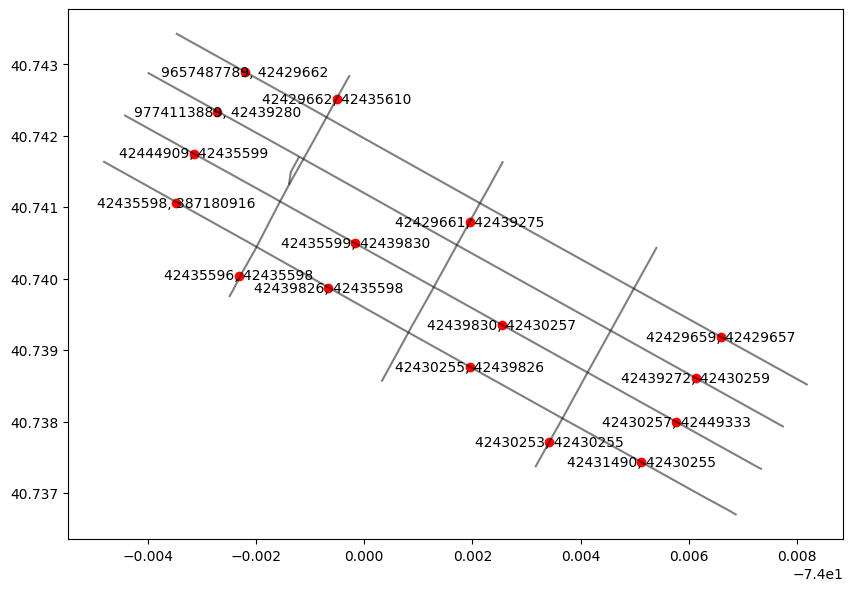

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
edges_gdf.plot(ax=ax, color='black', alpha=0.5)
unique_atr_gdf = atrs_with_streets_gdf.dissolve(by=['u','v','key'], as_index=False)
unique_atr_gdf.plot(ax=ax, color='red')

for idx, row in unique_atr_gdf.iterrows():
    plt.annotate(text= str(row['u']) + ', ' + str(row['v']), xy=row['atr_geometry'].coords[0], horizontalalignment='center', verticalalignment='center')

In [25]:
inbound_atrs_lst = {'14st_8av':('42435596','42435598'), '16st_8av':('42444909','42435599'), '18st_8av':('9657487789','42429662'), '14st_6av':('42430253','42430255'), '15st_6av':('42431490','42430255'), '17st_6av':('42439272','42430259'),'19st_7av': (None,None)}
outbound_atrs_lst = {'15st_8av':('42435598','387180916'),'17st_8av':('9774113889','42439280'), '19st_8av':('42429662','42435610'),'18st_6av':('42429659','42429657'),'16st_6av':('42430257','42449333'),'14st_7av':(None,None), '19st_6av':(None,None)}

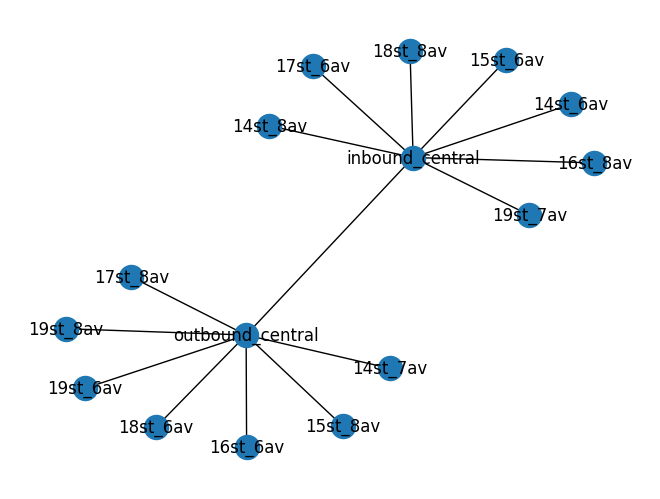

In [26]:
G = nx.Graph()

G.add_nodes_from(inbound_atrs_lst.keys())

G.add_nodes_from(outbound_atrs_lst.keys())

G.add_nodes_from(['inbound_central','outbound_central'])


for node in inbound_atrs_lst.keys():
    G.add_edge(node, 'inbound_central')

G.add_edge('inbound_central', 'outbound_central')

for node in outbound_atrs_lst.keys():
    G.add_edge('outbound_central', node)

nx.draw(G, with_labels=True)

## CVXPY
Minimize $$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2 + \lambda_1||\bar{F}L'F||_F + \lambda_2||FL'\bar{F}||_F + \lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F + \lambda_5||\bar{F} - F||_F$$
s.t.
1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [27]:
flow_df = atrs_with_streets_gdf[['vol','ts','u','v','key']]

In [28]:
# setup inflow dataframe
inflow_df = flow_df.pivot(index = ['u','v','key'], columns = ['ts'], values = ['vol'])

# convert inflow dataframe to array
F_in = inflow_df.to_numpy()

# set up outflow array
F_out = np.insert(F_in, 0, np.nan, axis=1)
F_out = F_out[:,:-1]

In [29]:
# Completed versions of F_in and F_out matrices, respectively.
F_in_c = cp.Variable(F_in.shape)
F_out_c = cp.Variable(F_out.shape)

In [30]:
# Net parking state matrix at time 0 (i.e., initial number of parked cars)
P0 = np.zeros((F_in.shape[0], 1))

In [31]:
# Omegas are binary matrices (with the same dimensions as F_in and F_out, respectively) where each element indicates whether the corresponding element in F_in / F_out is known (1) or unknown (0).
def indicator_function(arr):
    indicator_arr = np.zeros_like(arr)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if arr[i, j] != 1:
                indicator_arr[i, j] = 0
    return indicator_arr


omega_in = indicator_function(F_in)
omega_out = indicator_function(F_out)

# Regularization parameters that controls the trade-off between fitting the known elements and promoting a low-rank structure.
l1, l2, l3, l4, l5 = 1, 1, 1, 1, 1

$$||\bar{\Omega} \odot (\bar{F} - \bar{F_c})||_F^2 + ||\Omega \odot (F - F_c)||_F^2$$

In [32]:
expr1 = cp.square(cp.atoms.norm(cp.multiply(omega_in, (F_in - F_in_c)), p='fro'))
expr2 = cp.square(cp.atoms.norm(cp.multiply(omega_out, (F_out - F_out_c)), p='fro'))

$$\lambda_1||\bar{F}^\intercal L'F||_F + \lambda_2||F^\intercal L'\bar{F}||_F$$

In [33]:
F_in.shape

(16, 1198)

In [34]:
# Network prime graph
L_prime = nx.laplacian_matrix(G) # Laplacian graph

expr3 = l1 * cp.atoms.norm(F_in.T @ L_prime @ F_out, p='fro')
expr4 = l2 * cp.atoms.norm(F_out.T @ L_prime @ F_in, p='fro')

$$\lambda_3||\bar{F}(:, t+1) - \bar{F}(:, t)||_F + \lambda_4||F(:, t+1) - F(:, t)||_F$$

In [35]:
expr5 = l3 * cp.atoms.norm(F_in[:, 1:] - F_in[:, :-1], p='fro')
expr6 = l4 * cp.atoms.norm(F_out[:, 1:] - F_out[:, :-1], p='fro')

$$\lambda_5||\bar{F} - F||_F$$

In [36]:
expr7 = l5 * cp.atoms.norm(F_in - F_out, p='fro')

1. $F_c, \bar{F_c} > 0$
2. $F_c, \bar{F_c}$ contain integer elements
3. $P(t+1) = P(t) + \bar{F}(t) - F(t)$

In [37]:
# Define the constraints
constraints = [
    F_in_c >= 0,  # Ensure each element of F_in_c is positive
    F_out_c >= 0,  # Ensure each element of F_out_c is positive
    # assert for Parking matrix to be positive
    P0 + cp.cumsum(F_in_c - F_out_c, axis=1) >= 0
]

**Run Model**

In [40]:
problem = cp.Problem(objective=cp.Minimize(expr1 + expr2 + expr3 + expr4 + expr5 + expr6 + expr7),
                     constraints=constraints)

problem.solve(solver='GLPK')

SolverError: The solver GLPK is not installed.